In [ ]:
!pip3 install pandas openpyxl bertopic setuptools 'numpy<2' nltk spacy textstat textblob torch matplotlib ace_tools 
# add this to terminal every time - source .venv/bin/activate
#!pip3 install --upgrade pip

# IMPORT DATA - separate files country wise
Combine all the data 

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path

# 1. Set folder path and list files
folder_path = "/Users/vinitavader/Desktop/WJC/data"
file_paths = list(Path(folder_path).glob("*.xlsx"))

# 2. Set of countries that have translated responses
translated_countries = {"Brazil", "China", "Colombia", "Kazakhastan", "Poland", "Turkey"}

# 3. Process each file
def process_file(file_path):
    country = file_path.name.split('_')[0]  # Preserve original casing

    try:
        df = pd.read_excel(file_path)

        # 4. Define column pattern depending on translation status
        if country in translated_countries:
            # Look for _EN columns only
            lb_cols = [col for col in df.columns if re.match(r"LB_Open_Q[1-7]_EN$", col, flags=re.IGNORECASE)]
            smb_cols = [col for col in df.columns if re.match(r"SMB_Open_Q[1-7]_EN$", col, flags=re.IGNORECASE)]
        else:
            # Use standard non-EN columns
            lb_cols = [col for col in df.columns if re.match(r"LB_Open_Q[1-7]$", col, flags=re.IGNORECASE)]
            smb_cols = [col for col in df.columns if re.match(r"SMB_Open_Q[1-7]$", col, flags=re.IGNORECASE)]

        selected_cols = lb_cols + smb_cols
        if not selected_cols:
            print(f"⚠️ Skipping {file_path.name}: no relevant columns found")
            return None

        df = df[selected_cols].copy()

        # 5. Remove "_EN" suffix if present
        df.columns = [re.sub(r"_EN$", "", col, flags=re.IGNORECASE) for col in df.columns]

        # 6. Add pID and country
        df.insert(0, "pID", [f"{country}_p{i+1}" for i in range(len(df))])
        df.insert(1, "country", country)

        return df

    except Exception as e:
        print(f"❌ Skipping file {file_path.name}: {e}")
        return None

# 7. Collect all valid dataframes
dfs = []
for file_path in file_paths:
    df = process_file(file_path)
    if df is not None:
        if df.columns.duplicated().any():
            print(f"⚠️ Duplicate columns in {file_path.name}:")
            print(df.columns[df.columns.duplicated()].tolist())
        else:
            dfs.append(df)

# 8. Combine into one dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# 8. Replace empty strings with NaN
lb_cols = [f"LB_Open_Q{i}" for i in range(1, 8)]
smb_cols = [f"SMB_Open_Q{i}" for i in range(1, 8)]
combined_df[lb_cols + smb_cols] = combined_df[lb_cols + smb_cols].replace('', pd.NA)

# 9. Create Open_Q1 to Q7 using LB fallback to SMB
for i in range(1, 8):
    combined_df[f"Open_Q{i}"] = (
        combined_df.get(f"LB_Open_Q{i}").fillna(combined_df.get(f"SMB_Open_Q{i}")).astype(str)
    )

# 10. Unite Q1–Q7 and Q1–Q7_no6
open_q1_7_no6 = [f"Open_Q{i}" for i in range(1, 8) if i != 6]
open_q1_7 = [f"Open_Q{i}" for i in range(1, 8)]

combined_df["Open_Q1_Q7_no6"] = combined_df[open_q1_7_no6].apply(lambda row: ' '.join(row.dropna()), axis=1)
combined_df["Open_Q1_Q7"] = combined_df[open_q1_7].apply(lambda row: ' '.join(row.dropna()), axis=1)

# 11. Final dataframe selection
text_combined_df = combined_df[['pID', 'country'] + lb_cols + smb_cols + ['Open_Q1_Q7_no6', 'Open_Q1_Q7']]

text_combined_df

# IMPORT DATA - Merged files
Merged data sent by Berke 

In [2]:
import os
import pandas as pd
import re
from pathlib import Path

def clean_text(text):
    """Clean XML artifacts from text while preserving NA handling"""
    if pd.isna(text) or text == 'nan':
        return pd.NA
    
    # Convert to string and clean XML artifacts
    text = str(text)
    
    # Remove XML space preserve tags and entities
    text = re.sub(r'xml:space="preserve">', '', text)
    text = re.sub(r'&#xa;', ' ', text)  # Replace line breaks with spaces
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)  # Remove other XML entities
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Return NA if text becomes empty after cleaning
    return pd.NA if text == '' else text

# Load data
merged_df = (
    pd.read_csv("/Users/vinitavader/Desktop/WJC/data/WJC_firstwave_merged.csv")
    .pipe(lambda df: df.assign(
        **{col: df[col].replace('', pd.NA).apply(clean_text) for col in [f"LB_Open_Q{i}" for i in range(1, 8)] + [f"SMB_Open_Q{i}" for i in range(1, 8)] if col in df.columns}
    ))
    .pipe(lambda df: df.assign(
        **{
            f"Open_Q{i}": (
                df.get(f"LB_Open_Q{i}").fillna(df.get(f"SMB_Open_Q{i}"))
                # No need to apply clean_text again since original columns are already cleaned
            )
            for i in range(1, 8)
        }
    ))
    .pipe(lambda df: df.assign(
        Open_Q1_Q7_no6=df[[f"Open_Q{i}" for i in range(1, 8) if i != 6]]
            .apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1),
        Open_Q1_Q7=df[[f"Open_Q{i}" for i in range(1, 8)]]
            .apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
    ))
    # .loc[:, ['pID', 'country'] + 
    #      [f"LB_Open_Q{i}" for i in range(1, 8)] + 
    #      [f"SMB_Open_Q{i}" for i in range(1, 8)] + 
    #      ['Open_Q1_Q7_no6', 'Open_Q1_Q7']]
)

# Check the results
#print(merged_df.loc[:, ['pID', 'LB_Open_Q1', 'Open_Q1_Q7_no6', 'Open_Q1_Q7']])

In [ ]:
merged_df.columns

# Classify Text for the life domains
What are the domains that people talk about when it comes to difficult like decisions?
For example - Family, Career etc

In [ ]:
# --- Task 1: Count-Based Category Detection ---
import pandas as pd

# Define keyword-based decision categories
DEC_CATS = {
    'career':      ['job','work','career','profession','employment','business'],
    'relationships':['relationship','marriage','divorce','dating','partner','love'],
    'family':      ['family','children','parents','siblings','relatives'],
    'health':      ['health','medical','illness','doctor','treatment','surgery'],
    'financial':   ['money','financial','investment','debt','loan','purchase'],
    'education':   ['school','university','education','degree','study'],
    'location':    ['move','relocate','city','country','home','house'],
    'ethical':     ['right','wrong','moral','ethical','values','principle']
}

# Keyword count function
def decision_cats(text):
    if pd.isna(text):
        return {f"count_cat_{cat}": 0 for cat in DEC_CATS.keys()}
    
    text_l = str(text).lower()
    return {f"count_cat_{cat}": sum(text_l.count(kw) for kw in kws) for cat, kws in DEC_CATS.items()}

# Apply count-based classifier
count_df = merged_df["Open_Q1_Q7"].apply(decision_cats).apply(pd.Series)

# Add top count-based category
merged_df["count_category"] = count_df.idxmax(axis=1).str.replace("count_cat_", "")

# Combine results
merged_df = pd.concat([merged_df, count_df], axis=1)

# Preview
print(merged_df[["Open_Q1_Q7", "count_category"] + list(count_df.columns)])

# Save (optional)
#merged_df.columns.to_excel("count_based_classification.xlsx", index=False)

Checking if all the country data is matching the previous zero shot classification analysis 
1. Bazil (YES)
2. Canada (YES)
3. China (YES)
4. Colombia (YES)
5. Kazakhstan (YES)
6. Poland (YES)
7. Turkey (YES)
8. India (YES)
9. SriLanka (RUN)

In [ ]:
import pandas as pd

def compare_country_data(country_name):
    """
    Compare Open_Q1_Q7 data between merged_df and zero-shot Excel file for a specific country
    Shows summary stats and returns only the mismatched rows
    
    Parameters:
    country_name (str): Name of the country to compare (e.g., 'Brazil', 'USA', 'India')
    
    Returns:
    DataFrame: Only the rows with mismatches
    """
    
    # Get country data from merged_df
    merged_country = merged_df.loc[merged_df['country'] == country_name][['pID', 'Open_Q1_Q7']].reset_index(drop=True)
    
    # Construct Excel file path
    excel_file = f"/Users/vinitavader/Desktop/WJC/scripts/llm_zero_shot_{country_name}.xlsx"
    
    # Load the zero shot data
    try:
        zero_shot_df = pd.read_excel(excel_file)
        zero_shot_country = zero_shot_df[['pID', 'Open_Q1_Q7']].reset_index(drop=True)
    except FileNotFoundError:
        print(f"File not found: {excel_file}")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # Check if both dataframes have the same length
    if len(merged_country) != len(zero_shot_country):
        print(f"Warning: Different number of rows - merged: {len(merged_country)}, zero_shot: {len(zero_shot_country)}")
    
    # Handle different lengths by taking the minimum length
    min_len = min(len(merged_country), len(zero_shot_country))
    merged_country = merged_country.iloc[:min_len].reset_index(drop=True)
    zero_shot_country = zero_shot_country.iloc[:min_len].reset_index(drop=True)
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'merged_pID': merged_country['pID'].values,
        'merged_Open_Q1_Q7': merged_country['Open_Q1_Q7'].values,
        'zero_shot_pID': zero_shot_country['pID'].values,
        'zero_shot_Open_Q1_Q7': zero_shot_country['Open_Q1_Q7'].values,
        'match_Open_Q1_Q7': merged_country['Open_Q1_Q7'].values == zero_shot_country['Open_Q1_Q7'].values,
        'match_pID': merged_country['pID'].values == zero_shot_country['pID'].values
    })
    
    # Print summary
    total_rows = len(comparison_df)
    text_matches = comparison_df['match_Open_Q1_Q7'].sum()
    pid_matches = comparison_df['match_pID'].sum()
    
    print(f"Country: {country_name}")
    print(f"Total rows: {total_rows}")
    print(f"Text matches: {text_matches} ({text_matches/total_rows*100:.1f}%)")
    print(f"pID matches: {pid_matches} ({pid_matches/total_rows*100:.1f}%)")
    print(f"Text mismatches: {total_rows - text_matches}")
    
    # Return only mismatches
    mismatches = comparison_df.query("match_Open_Q1_Q7 == False")
    print(f"\nReturning {len(mismatches)} mismatched rows:")
    return mismatches

# Example usage:
# mismatches = compare_country_data('Brazil')
# mismatches = compare_country_data('USA')

In [ ]:
pd.set_option('display.max_rows', None)
# Example usage:
compare_country_data('Kazakhstan')

In [ ]:
from transformers import pipeline
import pandas as pd
import time
import numpy as np

# Define categories
DEC_CATS = {
    'career': [], 'relationships': [], 'family': [], 'health': [],
    'financial': [], 'education': [], 'location': [], 'ethical': []
}
candidate_labels = list(DEC_CATS.keys())

# Load zero-shot classifier once
zsc = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=-1  # Use CPU
)

def run_llm_classification_by_country(country_name, save=True, batch_size=50):
    df_country = merged_df[merged_df["country"] == country_name].copy()
    texts = df_country["Open_Q1_Q7"].tolist()
    all_results = []
    total = len(texts)
    
    for i in range(0, total, batch_size):
        batch = texts[i:i + batch_size]
        
        # Filter out NaN, None, and empty strings
        valid_batch = []
        batch_indices = []
        
        for idx, text in enumerate(batch):
            if pd.notna(text) and text and str(text).strip():
                valid_batch.append(str(text))
                batch_indices.append(idx)
        
        # Process batch results
        batch_results = []
        
        if valid_batch:  # Only process if there are valid texts
            try:
                res = zsc(valid_batch, candidate_labels=candidate_labels, multi_label=True)
                
                # Create results for the entire batch (including NaN positions)
                valid_idx = 0
                for idx in range(len(batch)):
                    if idx in batch_indices:
                        batch_results.append(res[valid_idx])
                        valid_idx += 1
                    else:
                        # Create dummy result for invalid/empty texts (will be handled later)
                        batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
                        
                print(f"[{time.ctime()}] Processed {min(i + batch_size, total)} / {total} for {country_name}")
                
            except Exception as e:
                print(f"⚠️ Batch {i}-{i + batch_size} failed: {e}")
                # Create dummy results for entire failed batch
                for _ in range(len(batch)):
                    batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
        else:
            print(f"⚠️ Batch {i}-{i + batch_size} skipped: no valid texts")
            # Create dummy results for entire batch of invalid texts
            for _ in range(len(batch)):
                batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
        
        all_results.extend(batch_results)
    
    # Extract predictions (keeping original structure)
    df_country["llm_category"] = [r["labels"][0] for r in all_results]
    
    # Create score dataframe (keeping original structure)
    score_df = pd.DataFrame([
        {f"llm_cat_{label}": score for label, score in zip(r["labels"], r["scores"])}
        for r in all_results
    ])
    
    # Now replace with NA where original text was NA/empty
    na_mask = df_country["Open_Q1_Q7"].isna() | (df_country["Open_Q1_Q7"] == '') | (df_country["Open_Q1_Q7"].astype(str).str.strip() == '')
    
    # Reset index to match score_df
    df_country = df_country.reset_index(drop=True)
    na_mask = na_mask.reset_index(drop=True)
    
    # Set llm_category to NA for empty texts
    df_country.loc[na_mask, "llm_category"] = np.nan
    
    # Set all score columns to NA for empty texts
    score_cols = [f"llm_cat_{label}" for label in candidate_labels]
    for col in score_cols:
        score_df.loc[na_mask, col] = np.nan
    
    df_country = pd.concat([df_country, score_df], axis=1)
    
    if save:
        filename = f"llm_zero_shot_{country_name}.xlsx"
        df_country.to_excel(filename, index=False)
        print(f"✔ Finished and saved: {filename}")
    
    return df_country

In [ ]:
# Run the classification
turkey_df = run_llm_classification_by_country("SriLanka")

In [ ]:
import pandas as pd
import glob
import os


def combine_all_countries():
    countries = ['USA', 'UK', 'Canada', 'Poland', 'China', 'Colombia','Brazil', 'Kazakhstan', 'India', 'Turkey', 'SriLanka']  # Add all your countries here
    
    dfs = []
    for country in countries:
        file_path = f"/Users/vinitavader/Desktop/WJC/scripts/llm_zero_shot_{country}.xlsx"
        try:
            df = pd.read_excel(file_path)
            dfs.append(df)
            print(f"✓ Loaded {country}: {len(df)} rows")
        except FileNotFoundError:
            print(f"⚠️ File not found: {country}")
        except Exception as e:
            print(f"⚠️ Error loading {country}: {e}")
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"\n✔ Combined {len(dfs)} files into {len(combined_df)} total rows")
        return combined_df
    else:
        print("No files were loaded")
        return pd.DataFrame()

In [ ]:
zero_shot_combined_df = combine_all_countries()

#zero_shot_combined_df.to_excel("zero_shot_check.xlsx", index=False)

In [ ]:
# Merge zero_shot_combined_df columns into merged_df using 'pID' as the key
# Exclude columns already present in merged_df to avoid duplication
cols_to_add = [col for col in zero_shot_combined_df.columns if col not in merged_df.columns or col == 'pID']

# Prepare a dataframe with only the new columns (including 'pID' for join)
zs_add = zero_shot_combined_df[cols_to_add]

# Merge on 'pID'
merged_df = merged_df.merge(zs_add, on='pID', how='left', suffixes=('', '_zs'))

# Show the updated dataframe shape and columns as a check
print(f"merged_df shape: {merged_df.shape}")
print("Columns added from zero_shot_combined_df:", [col for col in cols_to_add if col != 'pID'])

In [ ]:
# Export merged_df to Excel
merged_df.to_excel("merged_Wave1_zsc.xlsx", index=False)

In [ ]:
import matplotlib.pyplot as plt

# List of llm_cat columns (excluding 'llm_category' which is the label, not a score)
llm_cat_vars = [col for col in zs_add.columns if col.startswith('llm_cat_') and col != 'llm_category']

# Assign a color to each country
countries = merged_df['country'].unique()
colors = plt.cm.tab20.colors  # Up to 20 distinct colors
country_color_map = {country: colors[i % len(colors)] for i, country in enumerate(countries)}

# For each llm_cat variable, plot country-wise mean score as a horizontal bar chart
for cat_var in llm_cat_vars:
    # Compute mean score per country, drop NaN
    country_means = merged_df.groupby('country')[cat_var].mean().dropna()
    # Sort descending
    country_means = country_means.sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    bar_colors = [country_color_map[country] for country in country_means.index]
    country_means.plot(kind='barh', color=bar_colors)
    plt.gca().invert_yaxis()  # Highest at top
    plt.title(f"Mean Probability {cat_var} by Country")
    plt.xlabel("Mean Probability Score")
    plt.ylabel("Country")
    plt.xlim(0, 1)  # Set scale from 0 to 1
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# List of count_cat columns (count-based category scores)
llm_count_vars = [col for col in count_df.columns if col.startswith('count_cat_')]

# For each llm_count variable, plot country-wise mean score as a horizontal bar chart
for count_var in llm_count_vars:
    # Compute mean score per country, drop NaN
    country_means = merged_df.groupby('country')[count_var].mean().dropna()
    # Sort descending
    country_means = country_means.sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    bar_colors = [country_color_map[country] for country in country_means.index]
    country_means.plot(kind='barh', color=bar_colors)
    plt.gca().invert_yaxis()  # Highest at top
    plt.title(f"Mean {count_var} by Country")
    plt.xlabel("Mean Keyword Count")
    plt.ylabel("Country")
    plt.xlim(0, 7)  # Set scale from 0 to 7
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the order of domains is the same for both sets
domains = [v.replace('llm_cat_', '') for v in llm_cat_vars]

# Assign a unique color to each domain
colors = plt.cm.tab10.colors  # 10 distinct colors

for country in merged_df['country'].unique():
    df_country = merged_df[merged_df['country'] == country]
    llm_means = df_country[llm_cat_vars].mean()
    count_means = df_country[llm_count_vars].mean()
    
    x = np.arange(len(domains))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # LLM-based bars
    bars1 = ax1.bar(x - width/2, llm_means, width, label='LLM', color=colors)
    ax1.set_ylabel('Mean Probability (LLM)')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(x)
    ax1.set_xticklabels(domains, rotation=30)
    
    # Count-based bars (secondary axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, count_means, width, label='Keyword Count', color=colors, alpha=0.5)
    ax2.set_ylabel('Mean Keyword Count')
    ax2.set_ylim(0, 7)

    # Legend for domains
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(domains))]
    labels = domains
    ax1.legend(handles, labels, title="Domain", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add LLM/Count legend
    ax1.bar(0, 0, color='gray', label='LLM')
    ax2.bar(0, 0, color='gray', alpha=0.5, label='Keyword Count')
    plt.legend(loc='upper right')

    plt.title(f"Category Scores for {country}")
    plt.tight_layout()
    plt.show()

# TOPIC MODELING

In [5]:
merged_df = pd.read_excel("/Users/vinitavader/Desktop/WJC/data/merged_Wave1_text_classification.xlsx")

## 1. Preprocessing
Clean text: remove stopwords, punctuation, special characters, and extra whitespace.
 clean_text function; apply  to Open_Q1_Q7.

In [55]:
# Add to your preprocessing cell before topic modeling

import re

# Add generic verbs/stopwords to remove
GENERIC_WORDS = [
    r"\bdid\b", r"\bmake\b", r"\bmade\b", r"\bwas\b", r"\bwere\b", r"\bhas\b", r"\bhad\b", r"\bhave\b", r"\bwasn\b", r"\blet\b",
    r"\bget\b", r"\bgot\b", r"\bgetting\b", r"\bgotten\b", r"\bdo\b", r"\bdoes\b", r"\bdoing\b", r"\bgo\b", r"\bgoing\b", r"\blike\b"
]

def remove_generic_phrases(text):
    if pd.isna(text):
        return text
    text = str(text).lower()
    # Remove full phrases first
    phrases = [
        r"most difficult decision",
        r"hardest decision",
        r"most difficult",
        r"hardest",
        r"make decisions",
        r"_x000d_"
    ]
    for phrase in phrases:
        text = re.sub(phrase, '', text)
    # Remove single words and generic verbs
    words = [
        r"\bdecision\b",
        r"\bdifficult\b",
        r"\bhardest\b",
        r"\bdidn\b",
        r"\bdecisions\b"
    ] + GENERIC_WORDS
    for word in words:
        text = re.sub(word, '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else pd.NA

# Apply to your column before topic modeling
merged_df["Open_Q1_Q7_clean"] = (
    merged_df["Open_Q1_Q7"]
    .apply(clean_text)  # your existing cleaning
    .apply(remove_generic_phrases)
)

## 2. BERTopic Pipeline
Use outlined steps for embedding, dimensionality reduction, clustering, and topic modeling.

In [60]:

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

docs = merged_df['Open_Q1_Q7_clean'].dropna().tolist()

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = umap.UMAP(n_neighbors=30, n_components=3, min_dist=0.1, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='leaf', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words='english', min_df=5, ngram_range=(1,3))
ctfidf_model = ClassTfidfTransformer()
representation_model = MaximalMarginalRelevance(diversity=0.8)

topic_model = BERTopic(
  embedding_model=sbert_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model,
  calculate_probabilities=True,
  verbose=True
)

topics, probs = topic_model.fit_transform(docs)

# Reduce the number of topics to 10
topic_model.reduce_topics(docs, nr_topics=8)


2025-06-22 10:50:15,723 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/57 [00:00<?, ?it/s]

2025-06-22 10:50:22,051 - BERTopic - Embedding - Completed ✓
2025-06-22 10:50:22,051 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-22 10:50:23,395 - BERTopic - Dimensionality - Completed ✓
2025-06-22 10:50:23,396 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-22 10:50:23,429 - BERTopic - Cluster - Completed ✓
2025-06-22 10:50:23,430 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-22 10:50:24,048 - BERTopic - Representation - Completed ✓
2025-06-22 10:50:24,226 - BERTopic - Topic reduction - Reducing number of topics
2025-06-22 10:50:24,231 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-22 10:50:24,674 - BERTopic - Representation - Completed ✓
2025-06-22 10:50:24,675 - BERTopic - Topic reduction - Reduced number of topics from 13 to 8


In [61]:
# See how many documents are in the 'docs' list
print(f"Number of documents in docs: {len(docs)}")

Number of documents in docs: 1803


In [62]:
topic_info = topic_model.get_topic_info()
n_topics = (topic_info['Topic'] != -1).sum()
print(f"Number of topics (excluding outliers): {n_topics}")

Number of topics (excluding outliers): 7


3. Visualizations
built-in BERTopic plots for interpretation:

In [63]:

# Intertopic distance map (UMAP): Shows the relationship and distance between topics in 2D space.
fig1 = topic_model.visualize_topics()

# Top words per topic: Horizontal bar chart of the most important words for each topic.
fig2 = topic_model.visualize_barchart(n_words=10, top_n_topics = 10) # None means all topics will be shown.
# Ensure all y-axis labels (words) are displayed, even if in small font
fig2.update_yaxes(tickfont=dict(size=7.7))

# Topic similarity heatmap: Visualizes how similar topics are to each other.
fig3 = topic_model.visualize_heatmap()

# Hierarchical clustering of topics: Dendrogram showing topic groupings and hierarchy.
fig4 = topic_model.visualize_hierarchy()

# Documents in topic space: Projects your documents into topic space for exploration.
fig5 = topic_model.visualize_documents(docs)

# Display all plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()


# WHO TALKS MORE ABOUT TIME?

,country,count,time_phrases
0,China,34,"[2021, 2022, spring of 2018, summer of 2022, i..."
1,Kazakhstan,34,"[2025, summer of 2022, 2025, in 2016, in 2014,..."
2,India,22,"[2025, in 2014, 2006, in 2020, 2024, in 2021, ..."
3,Canada,19,"[in 2022, in 2008, 2025, spring of 2026, 2025,..."
4,SriLanka,19,"[2025, 2025, 2001, in 2009, 2025, in 2012, in ..."
5,Turkey,18,"[in 2019, in 2024, in 2017, 2022, in 2020, sum..."
6,USA,13,"[2025, in 2022, 2020, 2023, 2025, around 2018,..."
7,Brazil,11,"[in 1993, in 1990, in 2017, in 2014, 2019, in ..."
8,Colombia,11,"[in 2005, 1991, in 2008, in 2020, 2023, in 198..."
9,Poland,11,"[2024, 2022, in 2008, 2025, 2024, 2025, in 201..."


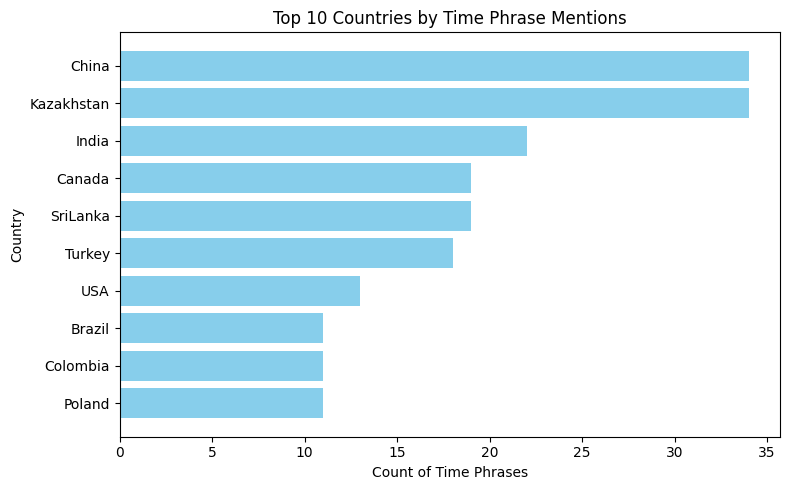

In [ ]:
import re
import numpy as np

# --- Extract time-related phrases from Open_Q1_Q7_clean ---

# Define patterns for years and time phrases
time_patterns = [
    r'\b(?:19|20)\d{2}\b',  # years like 1999, 2023
    r'(?:spring|summer|fall|autumn|winter)\s*(?:of)?\s*(?:19|20)\d{2}',  # e.g., summer 2020
    r'(?:in|since|during|around|by|from|until|till|before|after)\s+(?:19|20)\d{2}'  # e.g., in 2021
]
time_regex = re.compile('|'.join(time_patterns), re.IGNORECASE)

# Extract time phrases into a new column
time_phrases_df = merged_df.copy()
time_phrases_df["time_phrases"] = (
    time_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: time_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst[0] if lst else np.nan)
)

# Show the phrases df as before
#display(time_phrases_df[["country", "time_phrases"]])

# Group by country: count and collect phrases, dropping NA/nan phrases
country_time_counts = (
    time_phrases_df.dropna(subset=["time_phrases"])
    .groupby("country")
    .agg(
        count=("time_phrases", "count"),
        time_phrases=("time_phrases", lambda x: list(x))
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_time_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_time_counts["country"], country_time_counts["count"], color="skyblue")
plt.xlabel("Count of Time Phrases")
plt.ylabel("Country")
plt.title("Top 10 Countries by Time Phrase Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
